# Multi-Asset Feature Engineering in Financial ML

This notebook demonstrates how to engineer **robust** and **comparable features** across multiple financial assets with different price scales.

By using **relative transformations** (e.g., multi-window KAMA ratios, volatility differentials) followed by **z-score normalization**, we ensure that signals reflect **structural behaviors** rather than absolute price levels.

This technique enables us to:
- **Increase training data** by aggregating multiple assets,
- Improve **model robustness** and **generalization** across unseen instruments,
- Avoid **overfitting** to asset-specific price dynamics.

The resulting features are suitable for training **cross-asset machine learning models** for **regime detection**, **forecasting**, or **signal generation**.

👉 Full Newsletter about this subject available here: https://open.substack.com/pub/quantreo/p/multi-asset-feature-engineering-in


In [1]:
# Import the Features Engineering Package from Quantreo
import quantreo.features_engineering as fe

# Import numpy & pandas 
import numpy as np
import pandas as pd

# To display the graphics
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
# Import a dataset to test the functions and create new ones easily
from quantreo.datasets import load_generated_ohlcv
df = load_generated_ohlcv()

# Show the data
df

,open,high,low,close,volume
time,,,,,
2015-05-11 20:00:00,100.000000,100.358754,99.971765,100.113771,868.291731
2015-05-12 00:00:00,100.113771,100.274415,100.068157,100.197068,538.344102
2015-05-12 04:00:00,100.197068,100.621953,100.171421,100.550996,623.520889
2015-05-12 08:00:00,100.553515,100.789037,100.544627,100.759708,752.315201
2015-05-12 12:00:00,100.756989,100.975667,100.701889,100.769042,1260.121555
...,...,...,...,...,...
2024-11-13 04:00:00,102.104104,102.160879,101.878808,101.931978,431.101813
2024-11-13 08:00:00,101.931978,102.091758,101.931110,102.015341,1091.853172
2024-11-13 12:00:00,102.016217,102.082893,101.672509,101.853754,1848.353946


<br>

## Simulated Multi-Asset Data Generation

In this notebook, we aim to **highlight a common issue in financial machine learning**:  
certain features are **not bounded** and can vary significantly depending on the **asset's price level** or **market regime**.

To simulate this situation, we use the theoretical OHLCV dataset from `quantreo.datasets` and generate **six synthetic assets** by applying **randomized trends** and **volatility profiles** to different time slices.

These assets are designed to:
- Represent **different behaviors** (ranging, trending, volatile, etc.),
- Introduce **price scale disparities** between assets,
- Simulate cases where certain features can become **unstable or misleading** when applied across multiple instruments.

👉 This controlled setup allows us to **demonstrate the limitations** of raw features and motivates the use of **relative, normalized, and robust feature engineering techniques** in later sections.


In [3]:
def add_trend(df, mu, sigma):
    # Set a random seed for reproducibility — removed here for variability at each call
    np.random.seed()

    # Generate a global trend using a random walk with mean `mu` and volatility `sigma`
    trend = np.random.normal(mu, sigma, size=(len(df),)).cumsum().reshape(-1, 1)

    # Generate an additional noise component (not used here, but can simulate random fluctuations)
    fluct = np.random.normal(mu, 50, size=(len(df),)).cumsum().reshape(-1, 1)

    # Scale the OHLC prices by 10 to simulate a higher-priced asset,
    # then add the generated trend to simulate independent price dynamics
    df[["open", "high", "low", "close"]] = df[["open", "high", "low", "close"]] * 10 + trend

    # Return the modified DataFrame simulating a synthetic financial asset
    return df

In [4]:
# Generate 6 synthetic assets by applying different trends and volatilities
# Each asset is created using a different year from the original dataset to ensure independence

df_1 = add_trend(df.loc["2016"], 0.2, 10).reset_index(drop=True)   # Slight upward trend with moderate volatility
df_2 = add_trend(df.loc["2017"], 0.5, 20).reset_index(drop=True)   # Strong upward trend with high volatility
df_3 = add_trend(df.loc["2018"], -0.05, 10).reset_index(drop=True) # Mild downward trend with moderate volatility
df_4 = add_trend(df.loc["2019"], -0.0011, 20).reset_index(drop=True) # Flat/neutral trend with high volatility
df_5 = add_trend(df.loc["2020"], 0.1, 5).reset_index(drop=True)    # Light upward trend with low volatility
df_6 = add_trend(df.loc["2021"], 0.0, 20).reset_index(drop=True)   # No trend (random walk) with high volatility

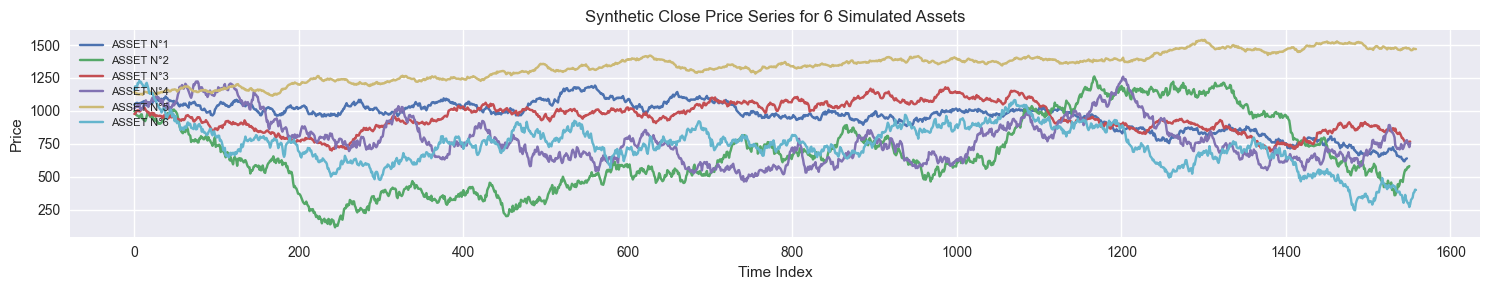

In [5]:
# Plot the close price of each synthetic asset to visualize the diversity of behaviors
plt.figure(figsize=(15, 3))
for data_frame, label in zip([df_1, df_2, df_3, df_4, df_5, df_6], [f"ASSET N°{i}" for i in range(1,7)]):
    plt.plot(data_frame["close"], label=label)
plt.legend(loc="upper left", fontsize=8)
plt.title("Synthetic Close Price Series for 6 Simulated Assets")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

<br>

## Feature Extraction on Synthetic Assets

In this section, we extract standard technical features commonly used in financial ML pipelines:
- **KAMA (Kaufman's Adaptive Moving Average)** to capture smoothed trend signals,
- **Price percentile range (25% to 75%)** to describe price dispersion within a window,
- **Close-to-close volatility estimator** for capturing price variability over time.

By applying these indicators to all six synthetic assets, we can visualize how differently each feature behaves depending on the **asset's price scale** and **market behavior**, even though the logic behind the feature remains the same.

👉 This highlights the need for robust preprocessing to make features comparable across instruments.


In [6]:
def get_features(df):
    # Compute Kaufman's Adaptive Moving Average with a short window
    df["kama_20"] = fe.trend.kama(df=df, col="close", l1=20, l2=2, l3=30)

    # Calculate the interquartile price range between the 25th and 75th percentile
    df["25_to_75"] = fe.candle.price_distribution(df, col="close", window_size=60, start_percentage=0.25, end_percentage=0.75)

    # Estimate volatility using the Close-to-Close method over a 60-period window
    df["ctc_vol_60"] = fe.volatility.close_to_close_volatility(df=df, close_col="close", window_size=60)

    return df


# Group all asset DataFrames into a list
assets = [df_1, df_2, df_3, df_4, df_5, df_6]

# Apply feature extraction to each asset
assets = [get_features(df) for df in assets]

# Unpack back to individual variables if needed
df_1, df_2, df_3, df_4, df_5, df_6 = assets

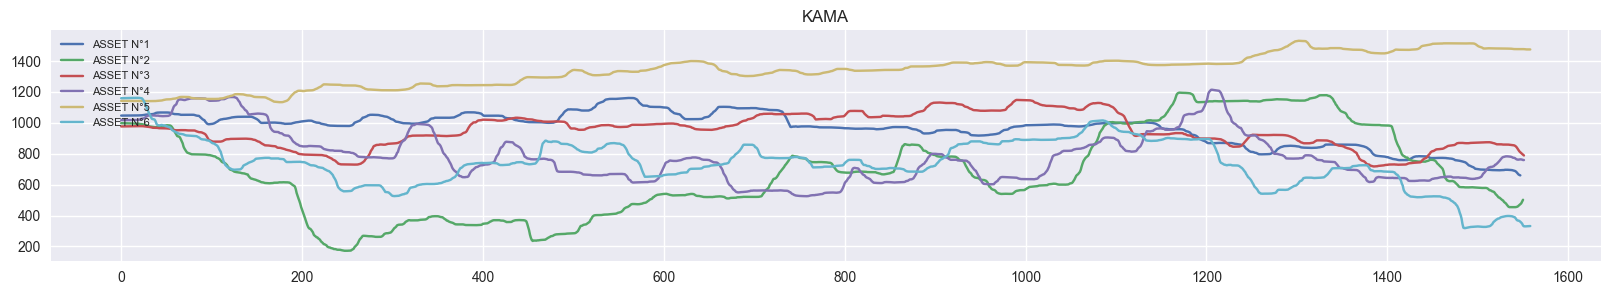

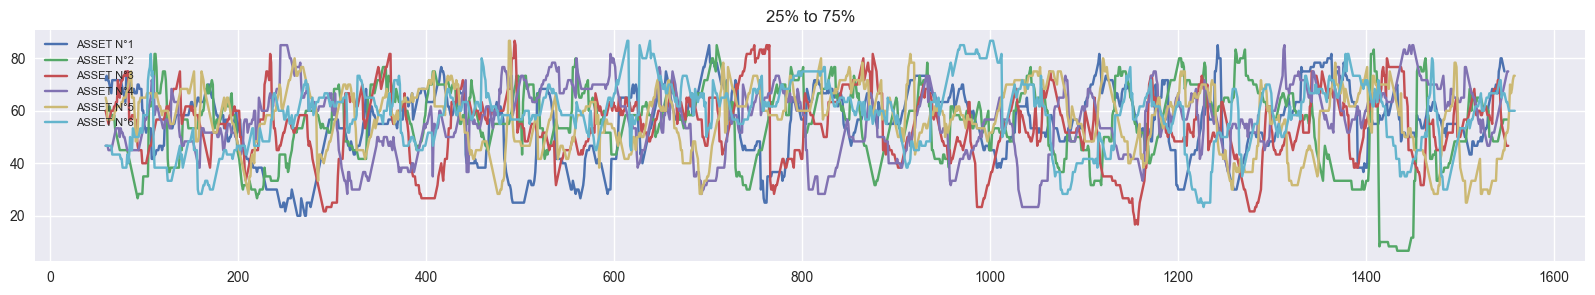

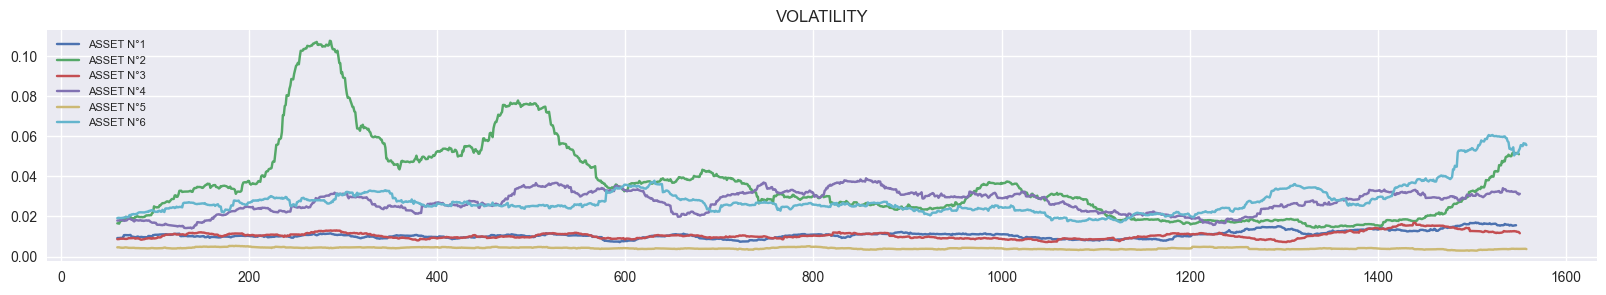

In [7]:
# Define the list of features to plot and their corresponding display titles
for col, title in zip(["kama_20", "25_to_75", "ctc_vol_60"], ["KAMA", "25% to 75%", "VOLATILITY"]):
    plt.figure(figsize=(20, 3))  # Set a wide plot for better readability

    # Plot each feature for each synthetic asset with proper labels
    for data_frame, label in zip([df_1, df_2, df_3, df_4, df_5, df_6], [f"ASSET N°{i}" for i in range(1,7)]):
        plt.plot(data_frame[col], label=label)

    # Set the plot title
    plt.title(title)

    # Display the legend in the top-left corner with smaller font size
    plt.legend(loc="upper left", fontsize=8)

    # Show the plot
    plt.show()


**Observation: Feature Inconsistency Across Assets**

As we can see from the plots above:

- The **KAMA** indicator, although trend-sensitive and smooth, produces values in **completely different ranges** across assets due to differences in price levels.
- The **close-to-close volatility** also varies **widely** between assets depending on their scale and volatility structure.
- Only the **25% to 75% percentile range** remains relatively bounded, since it’s more scale-independent by design.

This highlights a major issue in multi-asset machine learning workflows:  
➡️ **Many raw features are not inherently comparable across assets.**  
Training a model on such inconsistent inputs can introduce strong biases or lead to poor generalization.

✅ But don’t worry — in the next steps, we’ll address these issues **one by one**, transforming each feature into a **normalized and robust version** suitable for cross-asset modeling.

<br>

<br>

## Making Features Scale-Invariant with Relative Differences

To overcome the problem of unbounded and scale-sensitive features, we now compute **relative differences** between fast and slow versions of the same indicator.

Specifically:
- `diff_kama` compares the fast KAMA (20) to the slow KAMA (120),
- `diff_vol` compares short-term and long-term close to close volatility.

These relative features are expressed as **ratios**, meaning they are **dimensionless** and **naturally bounded around zero**.  
This transformation makes them:
- **Comparable across different assets**,
- Less sensitive to the asset's absolute price level,
- More informative about trend shifts and volatility changes.

This is the first step toward building a fully **normalized feature set** for multi-asset modeling.


In [8]:
def get_bounded_features(df):
    # Compute long-term KAMA to compare with the shorter one (already computed)
    df["kama_120"] = fe.trend.kama(df=df, col="close", l1=120, l2=2, l3=30)

    # Compute long-term CTC volatility
    df["ctc_vol_120"] = fe.volatility.close_to_close_volatility(df=df, close_col="close", window_size=120)

    # Calculate relative differences between short and long versions of each feature
    df["diff_kama"] = (df["kama_20"] - df["kama_120"]) / df["kama_120"]
    df["diff_vol"] = (df["ctc_vol_60"] - df["ctc_vol_120"]) / df["ctc_vol_120"]

    return df

# Apply the feature transformation to all synthetic assets
assets = [df_1, df_2, df_3, df_4, df_5, df_6]
assets = [get_bounded_features(df) for df in assets]
df_1, df_2, df_3, df_4, df_5, df_6 = assets

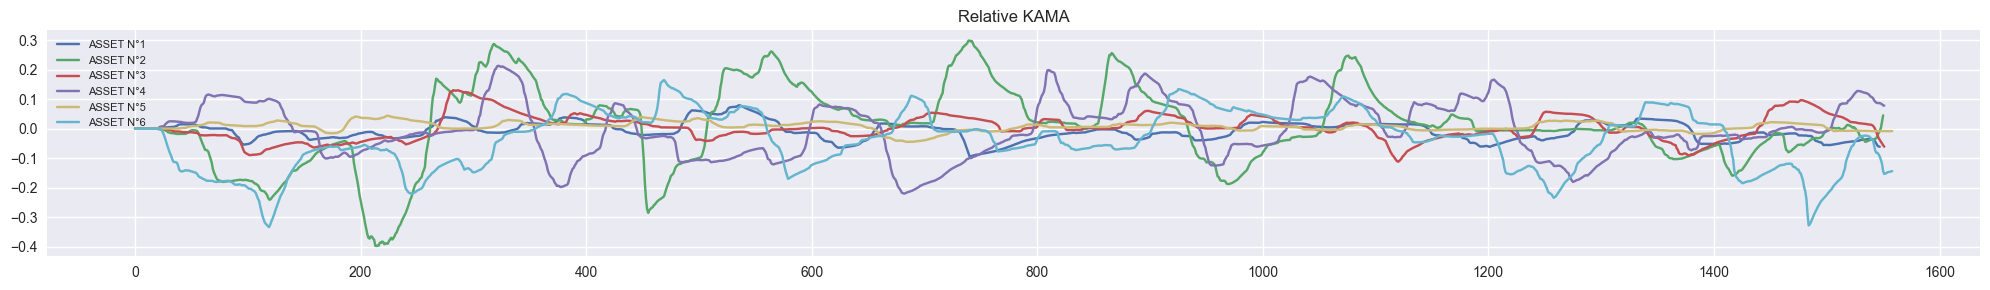

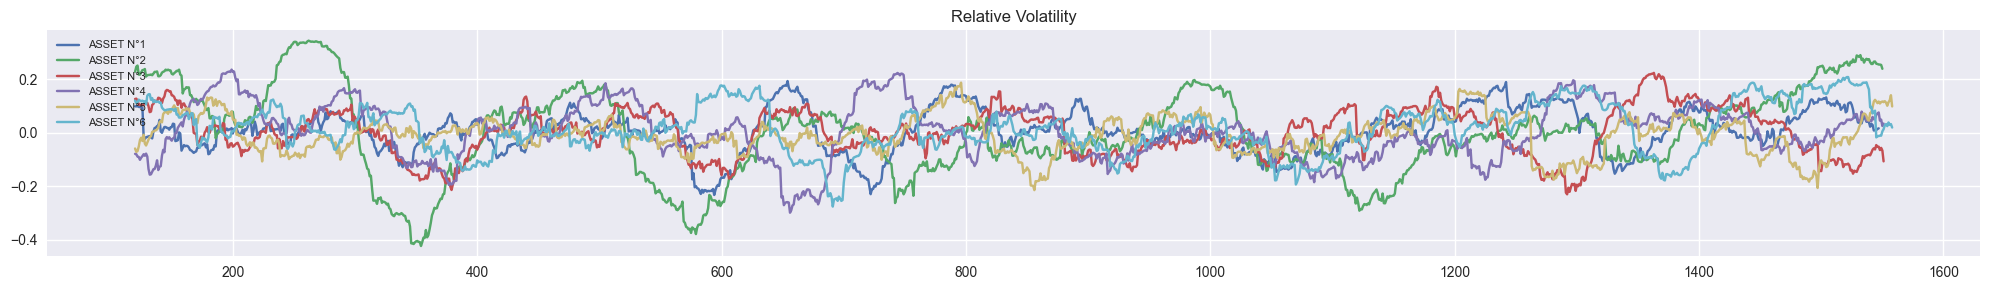

In [9]:
# Plot the relative (bounded) versions of KAMA and volatility across all assets
for col, title in zip(["diff_kama", "diff_vol"], ["Relative KAMA", "Relative Volatility"]):
    plt.figure(figsize=(20, 3))

    # Plot each asset's version of the feature with proper labeling
    for data_frame, label in zip([df_1, df_2, df_3, df_4, df_5, df_6], [f"ASSET N°{i}" for i in range(1,7)]):
        plt.plot(data_frame[col], label=label)

    # Add title and legend
    plt.title(title)
    plt.legend(loc="upper left", fontsize=8)
    plt.tight_layout()
    plt.show()


By computing relative differences (`diff_kama`, `diff_vol`) between short- and long-term indicators, we successfully **bounded** our features, all values now fluctuate around **zero**, regardless of the asset’s price.

However, we can clearly observe that the **amplitude and variance** of these features are still **very different across assets**. Some are tight and stable, others much more volatile.

➡️ This means that, although the features are now **scale-invariant**, they are still **not on the same scale**.

In the next step, we’ll apply **standardization (Z-score normalization)** to align the distributions across all assets. This will make the features truly comparable and usable for **multi-asset machine learning models**.

<br>

<br>

## Standardizing Features with Z-Score Normalization

Now that our features are bounded around zero, we take one final step to ensure full **scale comparability** across all assets:  
we apply **Z-score normalization**.

Z-score transforms each feature by subtracting its mean and dividing by its standard deviation:

$$
Z = \frac{x - \mu}{\sigma}
$$

This ensures that:
- Each feature is centered around **0**,
- All features have a **standard deviation of 1**,
- The impact of different amplitudes across assets is eliminated.

We apply this to our two bounded features:
- `diff_kama` → `z_diff_kama`
- `diff_vol` → `z_ctc_vol_120`

✅ After this transformation, the features become **fully standardized** and ready to be used as input for **cross-asset models** without introducing bias due to scale or asset-specific volatility.


In [10]:
def get_z_features(df):
    # Standardize the relative KAMA using Z-score
    df["z_diff_kama"] = (df["diff_kama"] - df["diff_kama"].mean()) / df["diff_kama"].std()

    # Standardize the relative volatility using Z-score
    df["z_ctc_vol_120"] = (df["diff_vol"] - df["diff_vol"].mean()) / df["diff_vol"].std()

    return df

# Apply Z-score standardization to all synthetic assets
assets = [df_1, df_2, df_3, df_4, df_5, df_6]
assets = [get_z_features(df) for df in assets]
df_1, df_2, df_3, df_4, df_5, df_6 = assets


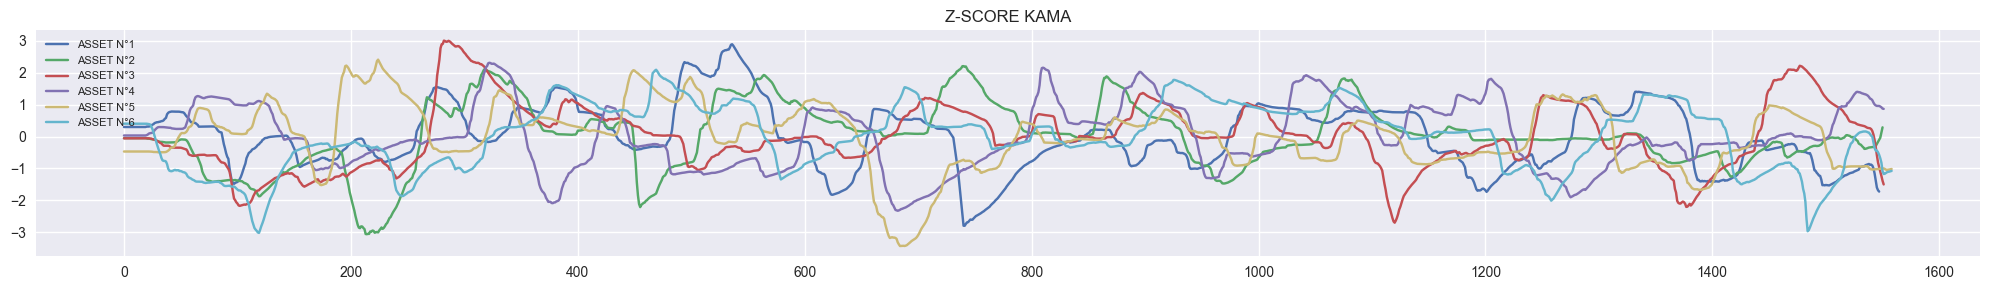

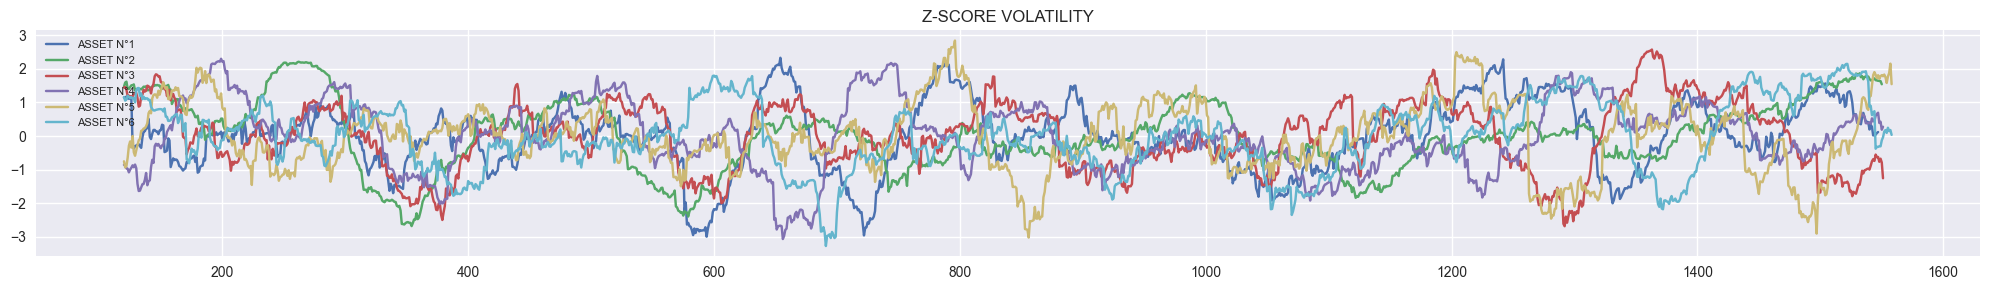

In [11]:
# Plot the standardized (Z-score) features for each synthetic asset
for col, title in zip(["z_diff_kama", "z_ctc_vol_120"], ["Z-SCORE KAMA", "Z-SCORE VOLATILITY"]):
    plt.figure(figsize=(20, 3))

    # Plot each asset's feature with labels
    for data_frame, label in zip([df_1, df_2, df_3, df_4, df_5, df_6], [f"ASSET N°{i}" for i in range(1,7)]):
        plt.plot(data_frame[col], label=label)

    # Add title and legend
    plt.title(title)
    plt.legend(loc="upper left", fontsize=8)
    plt.tight_layout()
    plt.show()


**⚠️ Important: Scaling Must Be Done Using the Training Set Only**

Whether using **Z-score normalization**, **Min-Max scaling**, or **robust percentile-based scaling**,  
it is essential to compute all transformation parameters (mean, std, min, max, percentiles) **only on the training data**.

These parameters must then be **reused to transform the test data**.

Applying scaling on the full dataset or using test data to compute statistics would introduce **data leakage**,  
leading to **unrealistically good performance** and **poor generalization in real-world applications**.

-> Always treat scaling as part of your preprocessing pipeline, fitted only on the training split and applied consistently to all future data.


<br>
<br>

## Final Conclusion: A Robust Multi-Asset Dataset Ready for Modeling

We started this notebook with synthetic assets exhibiting different price levels, volatility profiles, and behaviors.  
Initial feature extraction showed that raw indicators like KAMA or volatility were **not bounded** and **not comparable** across assets.

To fix this, we progressively applied:
- **Relative transformations** to remove price-scale dependency,
- **Z-score or Min-Max standardization** to align feature distributions,
- And respected best practices by ensuring all scaling was based on **training data only**.

As a result, we now have a **fully normalized and comparable feature set** across all six synthetic assets.  
These features are ready to be used in **machine learning models** without introducing bias or inconsistency between instruments.

This preprocessing pipeline enables **reliable, generalizable, and cross-asset training**, and lays a solid foundation for forecasting, regime detection, or signal generation tasks.
